## calculate the intra-*breed* distances and performing outlier analysis.

### Detailed Procedure

1. **Intra-*breed* Distance Calculation**:
   - For each *breed*, we extract the distances between individuals belonging to that same group.
   - We then calculate the mean \($\mu$\) and the standard deviation \($\sigma$\) of the distances between individuals of the same *breed*.
   
2. **Identification of Potential *Crossbreeds***:
   - For each individual, we calculate the average distance between them and other members of their *breed*.
   - If an individual’s average distance from their *breed* exceeds the overall intra-*breed* distance mean (for example, above \($\mu + 2\sigma $\)), then that individual is considered a potential *crossbreed*.

3. **Step-by-Step Algorithm**:
   - **Input**: Distance matrix \( D \), individuals’ breed assignments.
   - **Output**: List of individuals potentially *crossbreeds* or assigned to the wrong *breed*.

## Calculation of Intra-*breed* Distances

Calculate the IBS matrix for the entire dataset using plink:

```bash
plink --chr-set 26 no-xy no-mt --allow-no-sex \
   --bfile SMARTER-OA-OAR3-top-0.4.10/SMARTER-OA-OAR3-top-0.4.10 \
   --geno 0.1 --distance square gz ibs \
   --out SMARTER-OA-OAR3-top-0.4.10/SMARTER-OA-OAR3-top-0.4.10
```

In [1]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from src.features.utils import get_interim_dir

In [2]:
ibs_data = pd.read_table(get_interim_dir() / 'SMARTER-OA-OAR3-top-0.4.10/SMARTER-OA-OAR3-top-0.4.10.mibs.gz', header=None)
sample_names = pd.read_table(get_interim_dir() / 'SMARTER-OA-OAR3-top-0.4.10/SMARTER-OA-OAR3-top-0.4.10.mibs.id', header=None, names=['breed', "sample"])
distance_matrix = 1 - ibs_data

# assign names to the distance matrix
individuals = sample_names["sample"].tolist()
distance_matrix.index = individuals
distance_matrix.columns = individuals

In [3]:
# Now we have the distance matrix and the corresponding sample IDs
print(f"Distance matrix shape: {distance_matrix.shape}")
print(f"Number of samples: {len(individuals)}")

Distance matrix shape: (11837, 11837)
Number of samples: 11837


In [4]:
# Function to calculate intra-breed distances using an assignment DataFrame
def calculate_intra_breed_stats_with_assignments(distance_df, assignment_df):
    unique_breeds = assignment_df['breed'].unique()
    breed_stats = {}

    for breed in unique_breeds:
        # Get the samples for a given breed
        breed_samples = assignment_df[assignment_df['breed'] == breed]['sample'].values
        breed_distances = distance_df.loc[breed_samples, breed_samples].values

        # Extract only values above the diagonal (distances between distinct individuals)
        upper_triangle_indices = np.triu_indices_from(breed_distances, k=1)
        intra_breed_distances = breed_distances[upper_triangle_indices]

        # Calculate mean and standard deviation
        mean_distance = np.mean(intra_breed_distances)
        std_distance = np.std(intra_breed_distances)

        breed_stats[breed] = {
            'mean_distance': mean_distance,
            'std_distance': std_distance
        }

    return breed_stats

# Function to identify potential crossbreeds using the assignment DataFrame
def identify_outliers_with_assignments(distance_df, assignment_df, breed_stats, threshold=1.5):
    outliers = []
    for i, row in assignment_df.iterrows():
        ind = row['sample']
        breed = row['breed']

        # Get other samples of the same breed (excluding the current individual)
        breed_samples = assignment_df[(assignment_df['breed'] == breed) & (assignment_df['sample'] != ind)]['sample'].values
        distances_to_breed = distance_df.loc[ind, breed_samples].values

        # Calculate the mean distance to other individuals of the same breed
        mean_distance_to_breed = np.mean(distances_to_breed)

        # Compare with the intra-breed mean and standard deviation
        mean_intra_breed = breed_stats[breed]['mean_distance']
        std_intra_breed = breed_stats[breed]['std_distance']

        if mean_distance_to_breed > mean_intra_breed + threshold * std_intra_breed:
            outliers.append(ind)

    return outliers

In [5]:
# Impute NaN values with the mean of each row
distance_df_imputed = distance_matrix.fillna(distance_matrix.mean())

In [6]:
# Calculate the intra-breed statistics using the assignment DataFrame
breed_stats_with_assignments = calculate_intra_breed_stats_with_assignments(distance_df_imputed, sample_names)

# Identify potential crossbreeds with the assignment DataFrame
outliers_with_assignments = identify_outliers_with_assignments(distance_df_imputed, sample_names, breed_stats_with_assignments)

# prints some stats
print(f"Number of potential crossbreeds: {len(outliers_with_assignments)}")

# Display results
outliers_with_assignments, breed_stats_with_assignments

/home/cozzip/.conda/envs/SMARTER-database/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/cozzip/.conda/envs/SMARTER-database/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/cozzip/.conda/envs/SMARTER-database/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/cozzip/.conda/envs/SMARTER-database/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/cozzip/.conda/envs/SMARTER-database/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home

Number of potential crossbreeds: 77


(['CNOA-ALY-000009542',
  'GBOA-APD-000001238',
  'GBOA-APD-000001287',
  'CNOA-ARG-000006996',
  'ESOA-ASF-000006133',
  'CNOA-BAY-000009556',
  'FROA-BER-000000484',
  'ESOA-CAS-000006368',
  'ESOA-CAS-000006370',
  'GROA-CHI-000001868',
  'GROA-CHI-000004791',
  'GROA-CHI-000005500',
  'ESOA-CHU-000001890',
  'UYOA-CRR-000010029',
  'UYOA-CRR-000010037',
  'UYOA-CRR-000010045',
  'SEOA-DAL-000004846',
  'GBOA-DSH-000002090',
  'GBOA-DSH-000002097',
  'CNOA-DUO-000007721',
  'CNOA-DUO-000007740',
  'CNOA-DUO-000007752',
  'CNOA-DUO-000008501',
  'CNOA-DUO-000008508',
  'FROA-EUR-000000790',
  'GROA-FRZ-000004260',
  'GROA-FRZ-000005100',
  'GROA-FRZ-000005119',
  'GROA-FRZ-000005121',
  'GROA-FRZ-000005123',
  'GROA-FRZ-000005130',
  'GROA-FRZ-000005478',
  'INOA-GAR-000002533',
  'UGOA-HMR-000011757',
  'GBOA-ISF-000002588',
  'CNOA-KAZ-000009625',
  'CNOA-LTH-000009582',
  'UYOA-MER-000000225',
  'GROA-MYT-000005313',
  'GROA-MYT-000005453',
  'UNOA-OJA-000009498',
  'FROA-OUE-0000

In [7]:
# Perform t-SNE on the distance matrix with PCA initialization and reduced iterations
tsne = TSNE(
    n_components=2,          # Reduce data to 2 dimensions
    perplexity=40,           # Adjust perplexity for large datasets (try values between 30-50)
    max_iter=2000,           # Number of iterations, increase for better convergence
    learning_rate=200,       # Higher learning rate for large datasets
    init='pca',              # Initialize using PCA for faster convergence
    metric='euclidean',      # Use Euclidean distance metric
    random_state=42,         # For reproducibility
    verbose=True             # Enable verbose output to track progress
)
tsne_results = tsne.fit_transform(distance_df_imputed)

# Add t-SNE results to the sample_names DataFrame
sample_names['tsne-1'] = tsne_results[:, 0]
sample_names['tsne-2'] = tsne_results[:, 1]

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 11837 samples in 6.673s...
[t-SNE] Computed neighbors for 11837 samples in 23.699s...
[t-SNE] Computed conditional probabilities for sample 1000 / 11837
[t-SNE] Computed conditional probabilities for sample 2000 / 11837
[t-SNE] Computed conditional probabilities for sample 3000 / 11837
[t-SNE] Computed conditional probabilities for sample 4000 / 11837
[t-SNE] Computed conditional probabilities for sample 5000 / 11837
[t-SNE] Computed conditional probabilities for sample 6000 / 11837
[t-SNE] Computed conditional probabilities for sample 7000 / 11837
[t-SNE] Computed conditional probabilities for sample 8000 / 11837
[t-SNE] Computed conditional probabilities for sample 9000 / 11837
[t-SNE] Computed conditional probabilities for sample 10000 / 11837
[t-SNE] Computed conditional probabilities for sample 11000 / 11837
[t-SNE] Computed conditional probabilities for sample 11837 / 11837
[t-SNE] Mean sigma: 0.168129
[t-SNE] KL divergen

In [8]:
# Find all unique breeds that have outliers
outlier_breeds = sample_names[sample_names['sample'].isin(outliers_with_assignments)]['breed'].unique()

# Display the unique outlier breeds
outlier_breeds

array(['ALY', 'APD', 'ARG', 'ASF', 'BAY', 'BER', 'CAS', 'CHI', 'CHU',
       'CRR', 'DAL', 'DSH', 'DUO', 'EUR', 'FRZ', 'GAR', 'HMR', 'ISF',
       'KAZ', 'LTH', 'MER', 'MYT', 'OJA', 'OUE', 'RDR', 'RMN', 'ROM',
       'SAA', 'SAM', 'SDN', 'SOA', 'STH', 'TAR', 'TEX', 'TIB'],
      dtype=object)

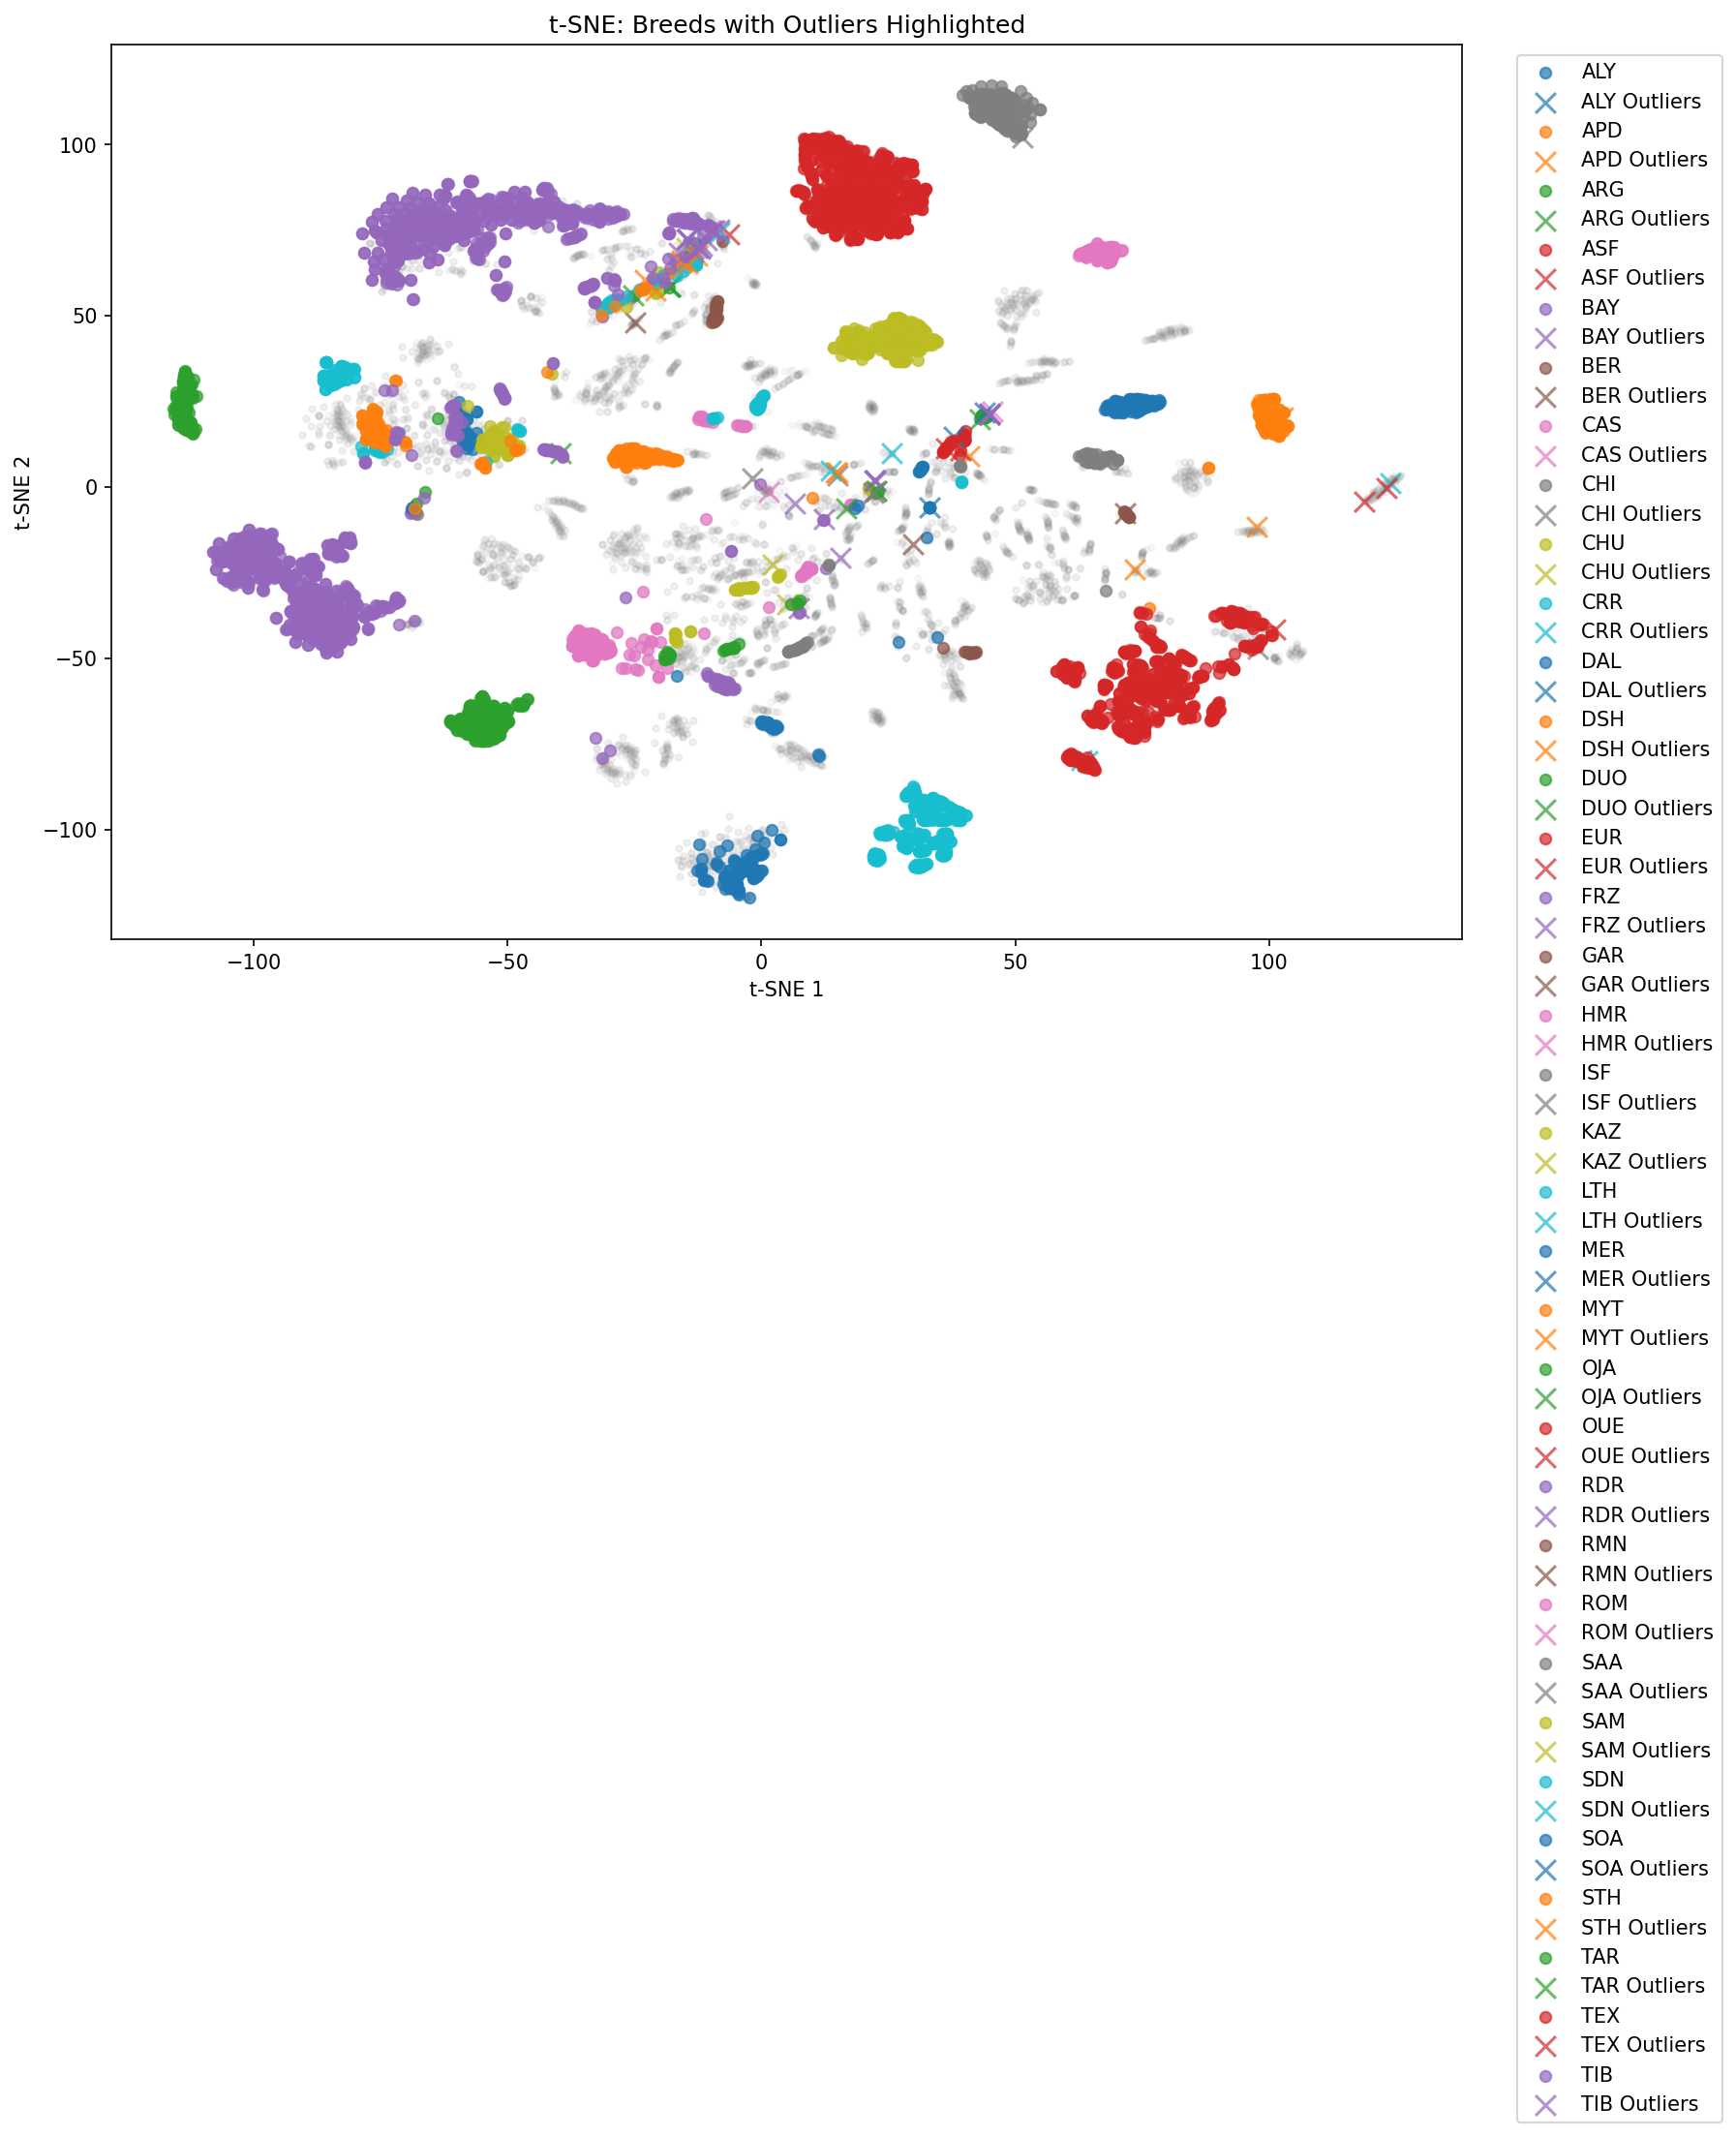

In [9]:
# Create a scatter plot with t-SNE results
plt.figure(figsize=(12, 8), dpi=150)

# Plot all samples in gray
plt.scatter(sample_names['tsne-1'], sample_names['tsne-2'], color='gray', alpha=0.05, s=10, label='_nolegend_')

# Plot samples from breeds in `outlier_breeds`.
for breed in outlier_breeds:
    # Get the data for the breed (excluding outliers)
    breed_data = sample_names[(sample_names['breed'] == breed) & (~sample_names['sample'].isin(outliers_with_assignments))]
    scatter = plt.scatter(breed_data['tsne-1'], breed_data['tsne-2'], label=breed, alpha=0.7, s=30)

    # Get the assigned color for the breed
    assigned_color = scatter.get_facecolor()[0]

    # Highlight outliers from the same breed with an 'x' marker
    outlier_breed_data = sample_names[(sample_names['breed'] == breed) & (sample_names['sample'].isin(outliers_with_assignments))]
    plt.scatter(
        outlier_breed_data['tsne-1'],
        outlier_breed_data['tsne-2'],
        label=f'{breed} Outliers',
        s=100,
        marker='x',
        color=assigned_color
    )

# Final plot settings
plt.title('t-SNE: Breeds with Outliers Highlighted')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))  # Adjust legend position if needed
plt.show()


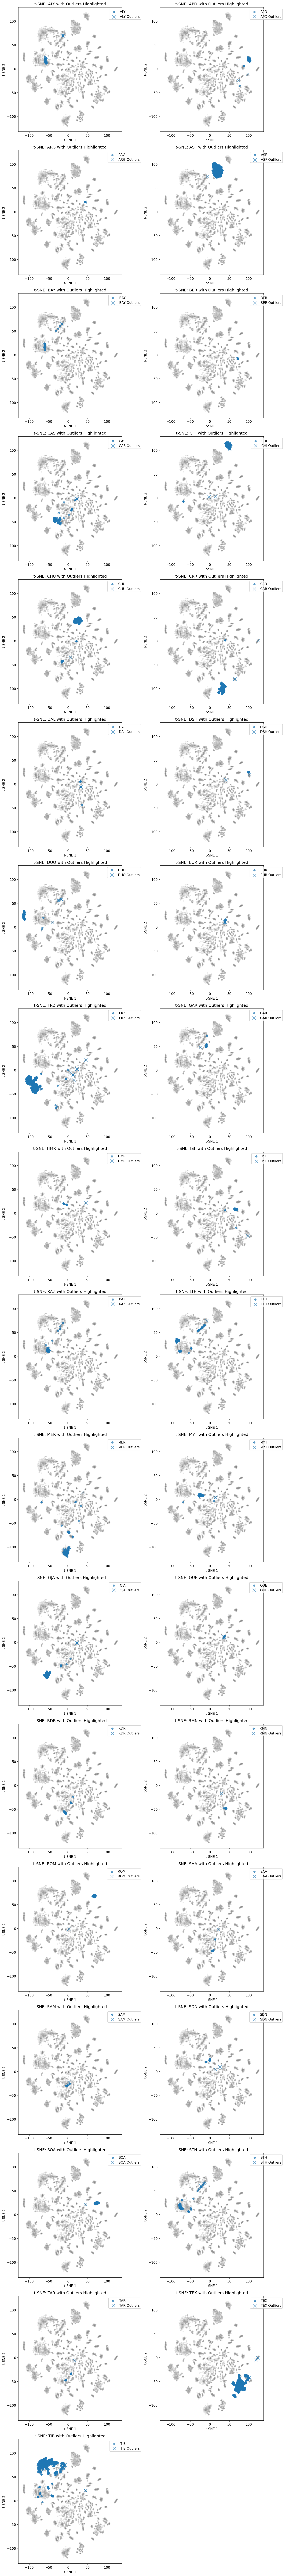

In [10]:
# determine the number of rows for the subplot grid
num_breeds = len(outlier_breeds)
num_rows = (num_breeds + 1) // 2

# create a figure with subplots
fig, axs = plt.subplots(num_rows, 2, figsize=(12, 6 * num_rows), dpi=150)

# if there is only one breed, axs will not be a list, so we convert it to a list
axs = axs.flatten()

# Plot samples from breeds in `outlier_breeds`.
for i, breed in enumerate(outlier_breeds):
    ax = axs[i]

    # Plot all samples in gray
    ax.scatter(sample_names['tsne-1'], sample_names['tsne-2'], color='gray', alpha=0.05, s=10, label='_nolegend_')

    # Get the data for the breed (excluding outliers)
    breed_data = sample_names[(sample_names['breed'] == breed) & (~sample_names['sample'].isin(outliers_with_assignments))]
    scatter = ax.scatter(breed_data['tsne-1'], breed_data['tsne-2'], label=breed, alpha=0.7, s=30)

    # Get the assigned color for the breed
    assigned_color = scatter.get_facecolor()[0]

    # Highlight outliers from the same breed with an 'x' marker
    outlier_breed_data = sample_names[(sample_names['breed'] == breed) & (sample_names['sample'].isin(outliers_with_assignments))]
    ax.scatter(
        outlier_breed_data['tsne-1'],
        outlier_breed_data['tsne-2'],
        label=f'{breed} Outliers',
        s=100,
        marker='x',
        color=assigned_color
    )

    # Final plot settings for each subplot
    ax.set_title(f't-SNE: {breed} with Outliers Highlighted')
    ax.set_xlabel('t-SNE 1')
    ax.set_ylabel('t-SNE 2')
    ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1))  # Adjust legend position if needed

# Remove any extra subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

# Adjust layout
plt.tight_layout()
plt.show()